In [1]:
#TODO:
#1/ train last 4 layers of the selected algo
#2/ RestNet50 - dans le state of the art ils atteignent tous des performances similaires -
#3/ optimiser quelques parameteres en general on le baisse le learning rate - le dropout aussi peut etre modifié. d'abord lancer avec des parametres par default, en fonction des courbes de loss
#4/ on prend un redeau pre-entrainé, on le fine-tune sur tres peu de donnee,
# logique - capacité analytique - interprête
#5/ papier de recherche que je cible c'est Facebook AI et Google Ai et Standford - le code est partagé donc on peut l'adapter à son use case
# suivre sur Linkedin - suivre des personnes connus qui publient en general des papiers
# suivre la page de Open AI et autre organise qui font les
# Google scolar - filtrer par date puis chercher si un code existe - certains articles sont liés à github
# site "papers with code"
# etre capable de mettre en place un projet machine learning en end-to-end - de data preparation à avoir un model qui fonctionne
# se renseigner si ils ont reellement un portefeuille client et combien de projets ils ont dans l'IA
# euranova - start-up -

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import timeit
from PIL import Image
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
import splitfolders
splitfolders.ratio('Images', output="Data2", seed=1337, ratio=(.75, 0.15,0.1))

Copying files: 20580 files [00:14, 1385.96 files/s]


## Creating Train, validation and test folders

In [4]:
train_dir = os.path.join('Data/', 'train')
validation_dir = os.path.join('Data/', 'val')

In [5]:
test_dir = os.path.join('Data/', 'test')

### Selecting the 13 folders with 150 pictures each

In [76]:
breed_list_150 = ['n02099601-golden_retriever',
                  'n02101556-clumber',
                  'n02102177-Welsh_springer_spaniel',
                  'n02102973-Irish_water_spaniel',
                  'n02104029-kuvasz',
                  'n02105056-groenendael',
                  'n02105162-malinois',
                  'n02106166-Border_collie',
                  'n02106382-Bouvier_des_Flandres',
                  'n02107142-Doberman',
                  'n02109961-Eskimo_dog',
                  'n02110627-affenpinscher',
                  'n02115913-dhole']

In [6]:
#Mettre un graphique
breed_list = [
    'n02085620-Chihuahua',
    'n02085782-Japanese_spaniel',
    'n02085936-Maltese_dog',
    'n02086079-Pekinese',
    'n02086240-Shih-Tzu',
    'n02086646-Blenheim_spaniel',
    'n02086910-papillon',
    'n02087046-toy_terrier',
    'n02087394-Rhodesian_ridgeback',
    'n02088094-Afghan_hound',
    'n02088238-basset',
    'n02088364-beagle']

In [9]:
import os
import shutil

path_train = "Data2/train"
path_test = "Data2/test"
path_val = "Data2/val"

count = 0
for folder_name in os.listdir(path_val):
    if not folder_name == '.DS_Store':
        if folder_name in breed_list:
            print('Keeping folder:', folder_name)
        else:
            dir_path = path_val + "/"+ folder_name
            print('Deleting folder:', folder_name)
            print('Deleting this path: ', dir_path)
            count = count + 1
            shutil.rmtree(dir_path)
print('Total folder deleted: ', count)

Deleting folder: n02097658-silky_terrier
Deleting this path:  Data2/val/n02097658-silky_terrier
Deleting folder: n02092002-Scottish_deerhound
Deleting this path:  Data2/val/n02092002-Scottish_deerhound
Deleting folder: n02099849-Chesapeake_Bay_retriever
Deleting this path:  Data2/val/n02099849-Chesapeake_Bay_retriever
Deleting folder: n02091244-Ibizan_hound
Deleting this path:  Data2/val/n02091244-Ibizan_hound
Deleting folder: n02095314-wire-haired_fox_terrier
Deleting this path:  Data2/val/n02095314-wire-haired_fox_terrier
Deleting folder: n02091831-Saluki
Deleting this path:  Data2/val/n02091831-Saluki
Deleting folder: n02102318-cocker_spaniel
Deleting this path:  Data2/val/n02102318-cocker_spaniel
Deleting folder: n02104365-schipperke
Deleting this path:  Data2/val/n02104365-schipperke
Deleting folder: n02090622-borzoi
Deleting this path:  Data2/val/n02090622-borzoi
Deleting folder: n02113023-Pembroke
Deleting this path:  Data2/val/n02113023-Pembroke
Deleting folder: n02105505-komon

## Loading dataset

In [10]:
BATCH_SIZE = 16
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1456 files belonging to 13 classes.
Metal device set to: Apple M1


2023-02-20 17:27:19.761789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 17:27:19.762503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 286 files belonging to 13 classes.


In [12]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 208 files belonging to 13 classes.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Loading MobileNetV2 model

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-02-20 17:28:02.038227: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(16, 5, 5, 1280)


In [16]:
base_model.trainable = False

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(12)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 12)


In [20]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [21]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [22]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [29]:
len(model.trainable_variables)

2

In [30]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2023-02-20 17:31:08.650389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 5s 99ms/step - loss: 8.4438 - accuracy: 0.1259


In [31]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 8.44
initial accuracy: 0.13


In [32]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


2023-02-20 17:16:20.982441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [2]:
#Mettre un graphique
test_breed_list = [
    'n02085620-Chihuahua',
    'n02085782-Japanese_spaniel',
    'n02085936-Maltese_dog',
    'n02086079-Pekinese',
    'n02086240-Shih-Tzu',
    'n02086646-Blenheim_spaniel',
    'n02086910-papillon',
    'n02087046-toy_terrier',
    'n02087394-Rhodesian_ridgeback',
    'n02088094-Afghan_hound',
    'n02088238-basset',
    'n02088364-beagle']

In [3]:
import glob
images = []
height = 299
width = 299
dim = (width, height)
labels=[]
start_time = timeit.default_timer()

import random
for index, breed in enumerate(test_breed_list):
    files = list(glob.iglob("Images"+"/"+breed+"/"+"*"))
    for f in files:
        img = Image.open(f)
        img = np.array(img)
        res_img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
        images.append(np.array(res_img))
        labels.append(breed.split("-")[1])

X = np.array(images)
y = np.array(labels)

preprocess_time = timeit.default_timer() - start_time

print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

# images = np.array(images)
# print(format(images))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 2289
Shape of images np.array : (2289, 299, 299, 3)
Total time : 8.56s


In [4]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

In [5]:
# Change X type
X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [6]:
format(y.shape)

'(2289,)'

In [7]:
# Verifie encoder created classes
print(encoder.classes_)

['Afghan_hound' 'Blenheim_spaniel' 'Chihuahua' 'Japanese_spaniel'
 'Maltese_dog' 'Pekinese' 'Rhodesian_ridgeback' 'Shih' 'basset' 'beagle'
 'papillon' 'toy_terrier']


In [8]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  1831
Test set size =  458


In [21]:
y_train

array([ 8,  1, 10, ...,  5, 10,  0])

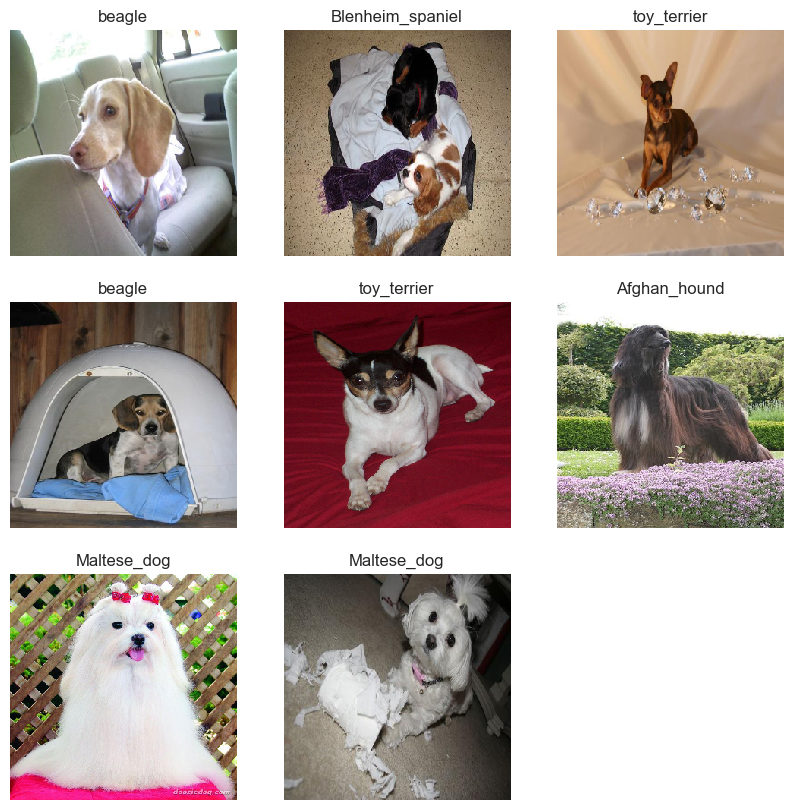

In [53]:
class_names = encoder.classes_

plt.figure(figsize=(10, 10))

images = []
labels = []
for image in x_train[16:24]:
    images.append(image)
for label in y_train[16:24]:
    labels.append(label)

for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype('uint8'), interpolation='nearest')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [57]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Metal device set to: Apple M1


2023-02-18 19:58:34.006113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-18 19:58:34.006686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(299, 299, 3)


2023-02-18 20:10:22.811118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-02-18 20:10:23.580669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-02-18 20:10:24.351709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-02-18 20:10:25.062199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-02-18 20:10:25.701530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-02-18 20:10:26.510180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-02-18 20:10:27.157505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-02-18 20:10:27.792347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-02-18 20:10:28.425259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


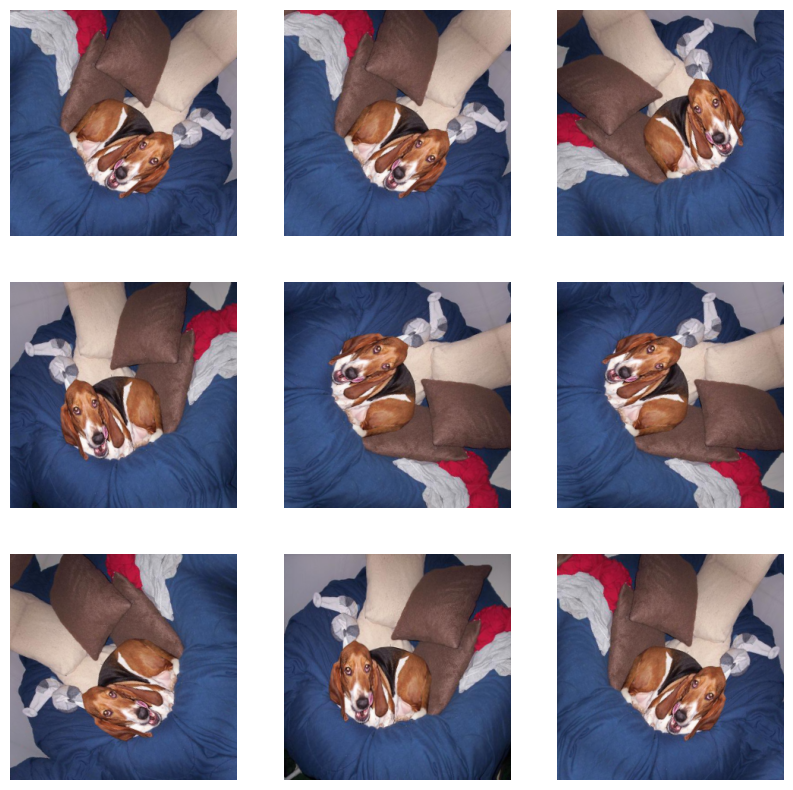

In [71]:
class_names = encoder.classes_

plt.figure(figsize=(10, 10))
first_image = x_train[0]
print(format(first_image.shape))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescale pixel values

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)